In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
from skimage.data import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data
import csv
import tensorflow as tf
%matplotlib inline

# Define the data paths
input_bson_filename = '/data/data/train_example.bson'
output_tfrecords_filename = '/data/data/train_example.tfrecords'
category_data=pd.read_csv("../data/category_names.csv")

# Explore the category names

In [4]:
print("Total categories are:", len(category_data))

def concat_category_names(row):
    return "|".join([row['category_level1'],row['category_level2'],row['category_level3']])

category_data['category_name'] = category_data.apply(concat_category_names, axis=1)

category_names_df = category_data[['category_id', 'category_name']]
category_names_dict = category_names_df.set_index('category_id').T.to_dict('list')
category_names_dict[1000021794]

('Total categories are:', 5270)


['ABONNEMENT / SERVICES|CARTE PREPAYEE|CARTE PREPAYEE MULTIMEDIA']

In [91]:
inception_2015_prediction_file = open("../inception_feature_2015.txt", "r")
# inception_2015_prediction = inception_2015_prediction_file.readlines()
inception_2015_prediction = dict()
for line in inception_2015_prediction_file:
    values = line.split(" ")
    if str(values[0]) not in inception_2015_prediction:
        inception_2015_prediction[str(values[0])] = values[1:]

inception_2016_prediction_file = open("../inception_feature_2016.txt", "r")
# inception_2016_prediction = inception_2015_prediction_file.readlines()
inception_2016_prediction = dict()
for line in inception_2016_prediction_file:
    values = line.split(" ")
    if str(values[0]) not in inception_2016_prediction:
        inception_2016_prediction[str(values[0])] = values[1:]
    
inception_2015_prediction['3']
inception_2016_prediction['3']

['folding', 'chair\n']

# Load the train_example data

In [110]:
# Simple data processing
data = bson.decode_file_iter(open(input_bson_filename, 'rb'))

(18, ['MUSIQUE|CD|CD MUSIQUE DU MONDE'])
2015 prediction: packet

2016 prediction: hard
image shape: 
(180, 180, 3)


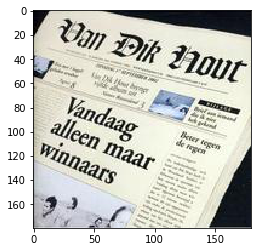

In [127]:
product = next(data)
imgs = product['imgs']
product_id = product['_id']
category_id = product['category_id']
print(product_id, category_names_dict[category_id])
print("2015 prediction: " + inception_2015_prediction[str(product_id)][0])
print("2016 prediction: " + inception_2016_prediction[str(product_id)][0])

picture=imread(io.BytesIO(imgs[0]['picture']))
# print(product_id)
plt.imshow(picture)
print("image shape: ")
print(picture.shape)

# Convert bson into tfrecords

## Reading tfrecord file without defining a graph

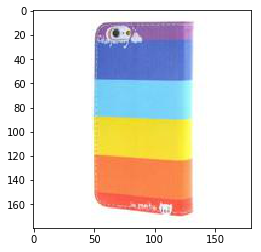

In [5]:
height = 180
width = 180
reconstructed_images = []
opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
record_iterator = tf.python_io.tf_record_iterator(path=output_tfrecords_filename, options=opts)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
#     height = int(example.features.feature['height']
#                                  .int64_list
#                                  .value[0])
    
#     width = int(example.features.feature['width']
#                                 .int64_list
#                                 .value[0])
    img_string = (example.features.feature['img_raw']
                                  .bytes_list
                                  .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
            
    reconstructed_images.append(reconstructed_img)
    
plt.imshow(reconstructed_images[2])

In [6]:
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

def read_and_decode(filename_queue):
    
    opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
    reader = tf.TFRecordReader(options=opts)

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
#         'height': tf.FixedLenFeature([], tf.int64),
#         'width': tf.FixedLenFeature([], tf.int64),
#         'product_id': tf.FixedLenFeature([], tf.int64),
        'img_raw': tf.FixedLenFeature([], tf.string),
#         'inception_output': tf.FixedLenFeature([2048], tf.float32),
        'label_one_hot': tf.FixedLenFeature([], tf.int64),
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image_raw = tf.decode_raw(features['img_raw'], tf.uint8)    
#     height = tf.cast(features['height'], tf.int32)
#     width = tf.cast(features['width'], tf.int32)
    label = tf.cast(features['label_one_hot'], tf.int32)
    
    image_shape = tf.stack([IMAGE_HEIGHT, IMAGE_WIDTH, 3])    
    image = tf.reshape(image_raw, image_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, -1), dtype=tf.int32)
    #we could add preprocessing here.
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    images, labels = tf.train.shuffle_batch( [resized_image, label],
                                                 batch_size=2,
                                                 capacity=10,seed=1,
                                                 num_threads=2,
                                                 min_after_dequeue=5)
    return images, labels

## Defining the graph to read and batch images from .tfrecords

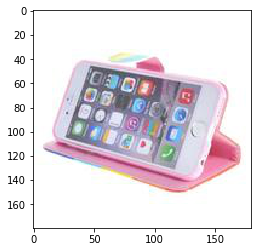

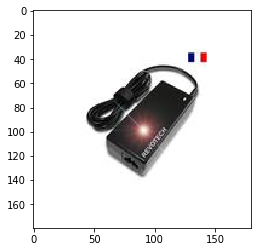

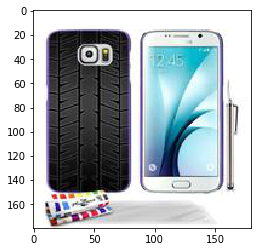

In [7]:
filename_queue = tf.train.string_input_producer([output_tfrecords_filename])

img_batch, label_batch = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    sess.run(init_op)

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # Let's read off 3 batches just for example
    for i in range(3):
        imgs, labels = sess.run([img_batch, label_batch])
#         print(category_names_dict[labels[0]])
        plt.figure()
        plt.imshow(imgs[0, :, :, :])
    
    coord.request_stop()
    coord.join(threads)